<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/agni/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Example



## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wfdb
!pip install scikit-learn
!pip install matplotlib
!pip install pyedflib

In [4]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram, stft
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

In [5]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# train_dir = '/content/train/'
# os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


In [41]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Load QRS annotations
qrs_annotations = wfdb.rdann("/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf", "qrs")

# Extract QRS peak sample indices
qrs_peaks = qrs_annotations.sample

print("QRS Peak Sample Indices:", qrs_peaks[:10])

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
QRS Peak Sample Indices: [ 183  651 1118 1583 2049 2514 2982 3451 3920 4389]


In [37]:
rr_intervals = np.diff(qrs_peaks)
print("RR Intervals (samples):", rr_intervals[:10])

RR Intervals (samples): [468 467 465 466 465 468 469 469 469 468]


In [38]:
rr_intervals_sec = rr_intervals / fs
print("RR Intervals (seconds):", rr_intervals_sec[:10])

RR Intervals (seconds): [0.468 0.467 0.465 0.466 0.465 0.468 0.469 0.469 0.469 0.468]


In [39]:
instantaneous_hr_hz = 1 / rr_intervals_sec
instantaneous_hr_bpm = instantaneous_hr_hz * 60
print("Instantaneous Heart Rates (Hz):", instantaneous_hr_hz[:10])
print("Instantaneous Heart Rates (bpm):", instantaneous_hr_bpm[:10])

Instantaneous Heart Rates (Hz): [2.13675214 2.14132762 2.15053763 2.14592275 2.15053763 2.13675214
 2.13219616 2.13219616 2.13219616 2.13675214]
Instantaneous Heart Rates (bpm): [128.20512821 128.47965739 129.03225806 128.75536481 129.03225806
 128.20512821 127.93176972 127.93176972 127.93176972 128.20512821]


## Testing

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Σχήμα signals: (300000, 5)


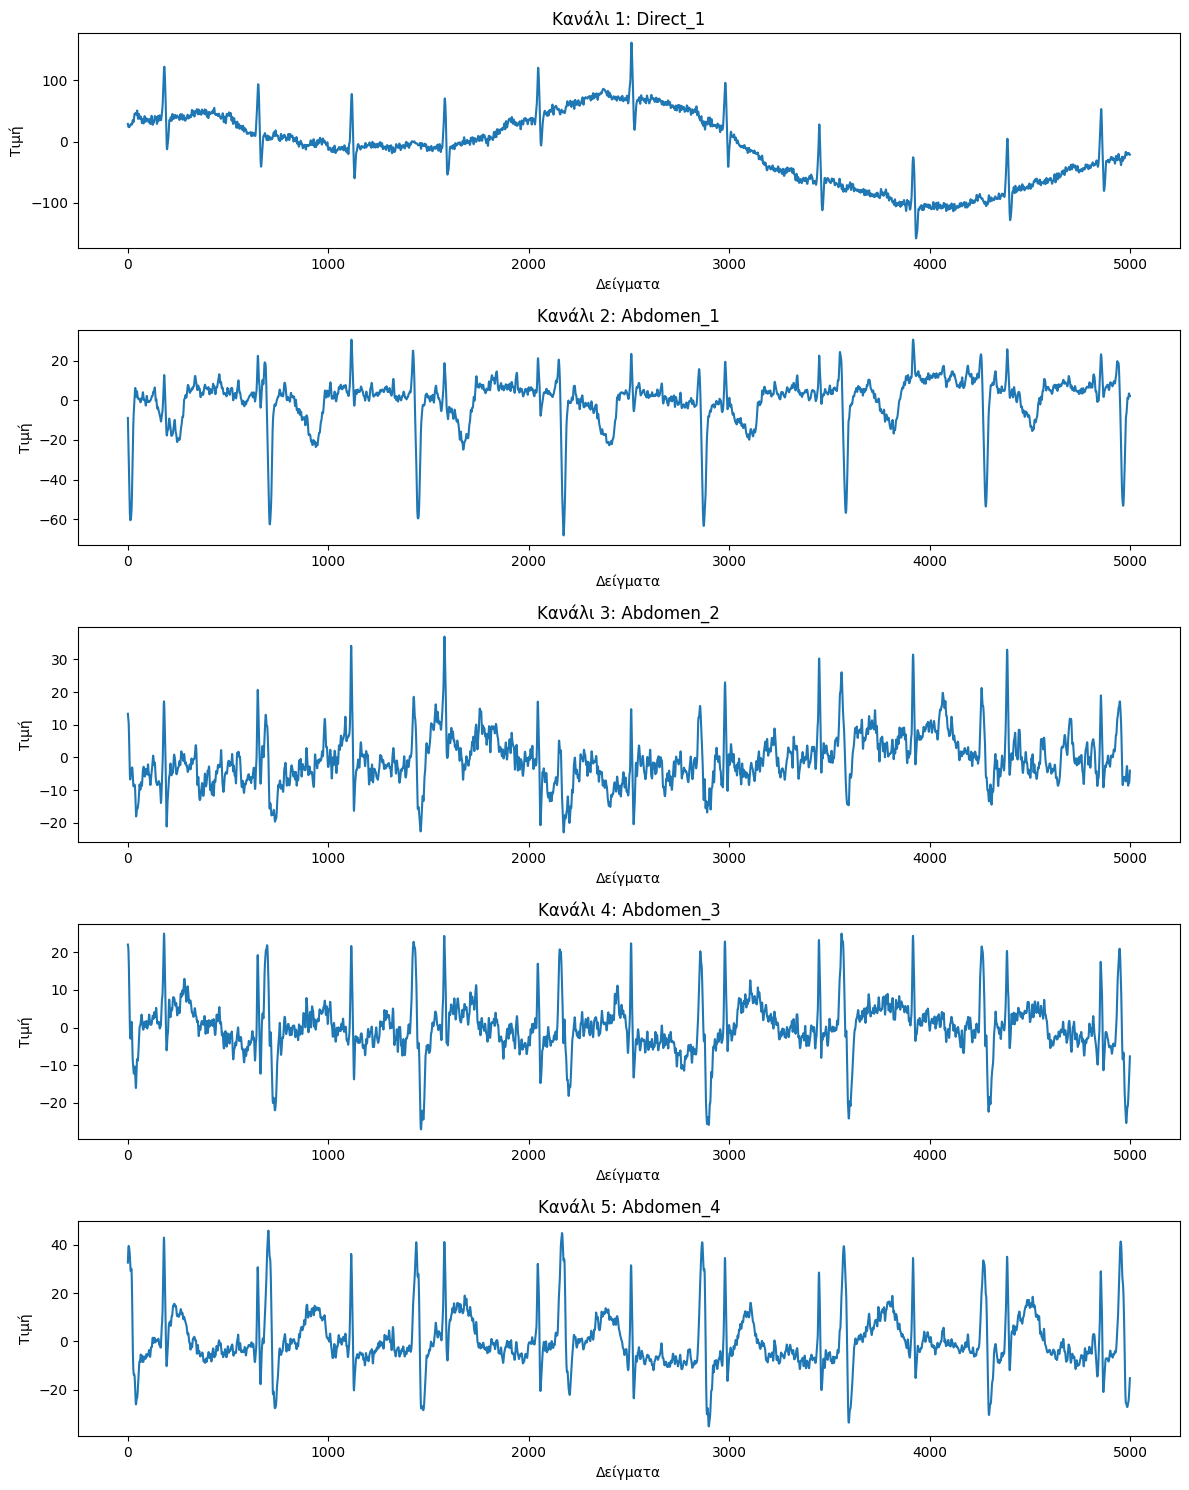

In [ ]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
signals = np.array(signals_list).T
print("Σχήμα signals:", signals.shape)

# Επιλογή των πρώτων 5 δευτερολέπτων (για fs=1000, αυτό σημαίνει 5000 δείγματα)
n_sec = 5
first_n_sec = signals[:n_sec * int(fs), :]

# Οπτικοποίηση κάθε καναλιού σε διαφορετικό subplot
n_channels = first_n_sec.shape[1]
plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(first_n_sec[:, i])
    plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')

plt.tight_layout()
plt.show()


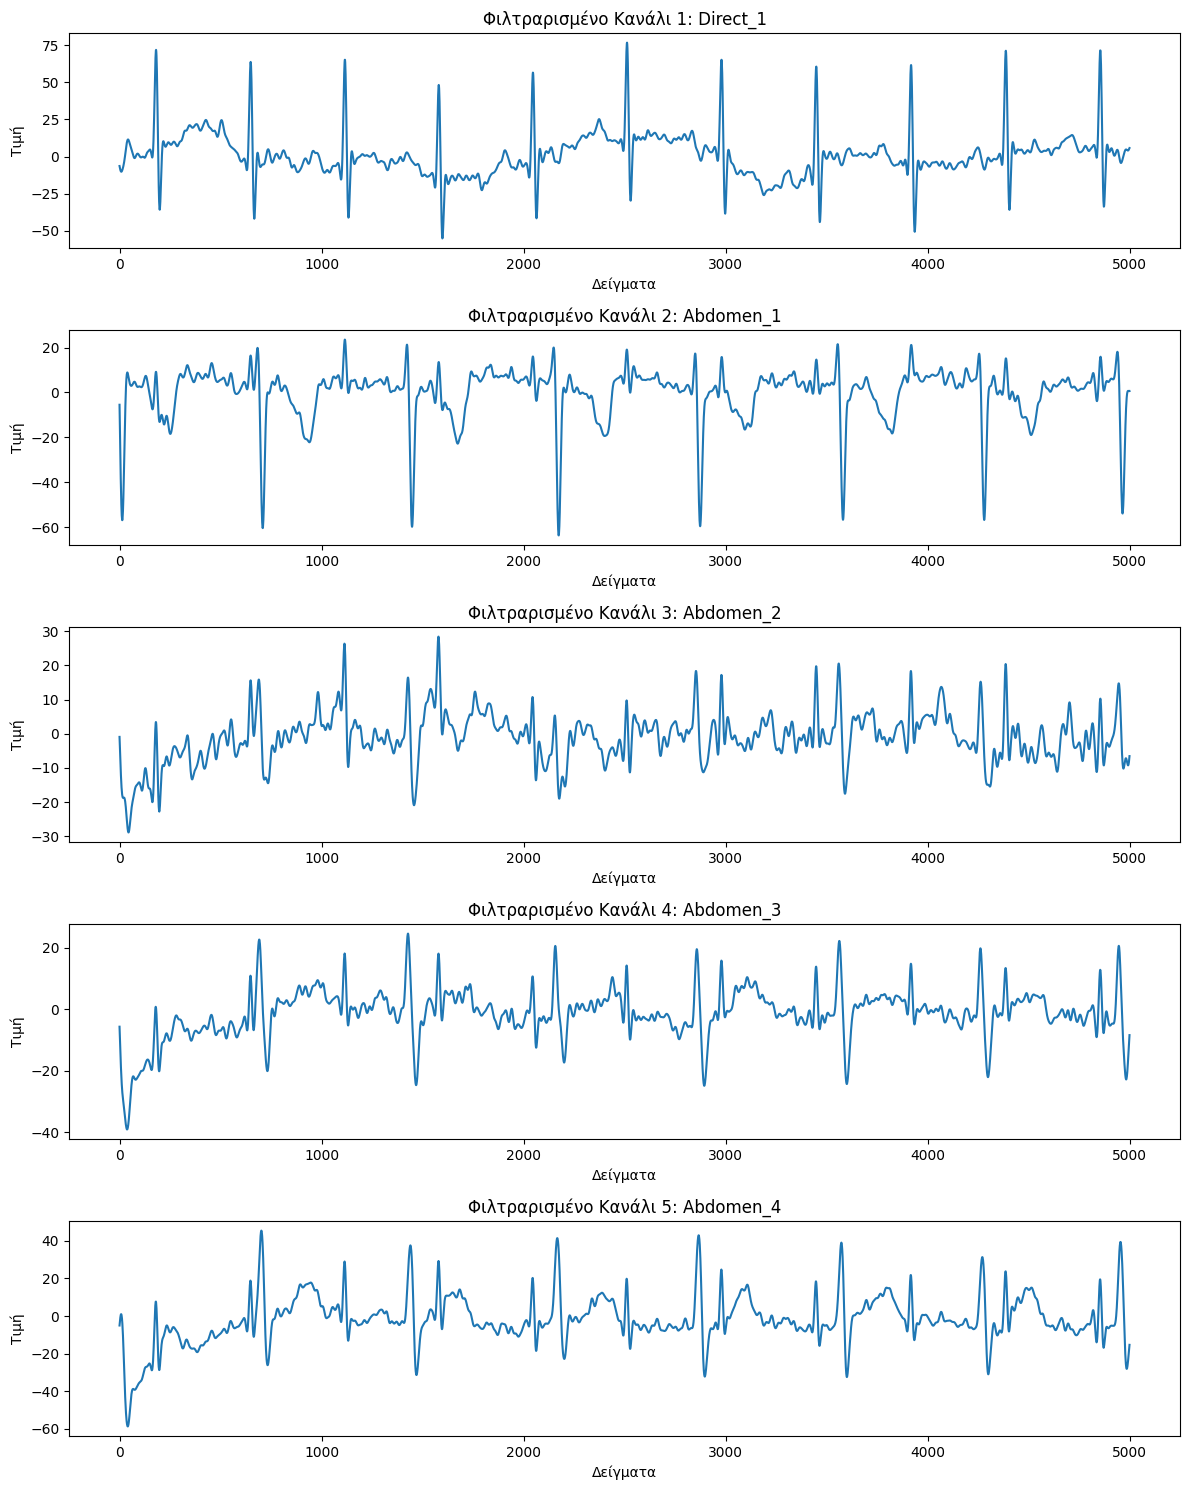

In [ ]:
# Συνάρτηση για ζωνοπερατό (bandpass) φιλτράρισμα
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # συχνότητα Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Ορισμός παραμέτρων φίλτρου
lowcut = 0.5   # Κατώφλι (Hz)
highcut = 40   # Άνω φράγμα (Hz)

# Εφαρμογή του φίλτρου σε κάθε κανάλι του σήματος
filtered_signals = np.zeros_like(signals)
for i in range(signals.shape[1]):
    filtered_signals[:, i] = bandpass_filter(signals[:, i], lowcut, highcut, fs, order=4)

# Οπτικοποίηση των φιλτραρισμένων σημάτων για τα πρώτα 5 δευτερόλεπτα
n_seconds = 5
first_n_sec_filtered = filtered_signals[:n_seconds * int(fs), :]
n_channels = first_n_sec_filtered.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(first_n_sec_filtered[:, i])
    plt.title(f'Φιλτραρισμένο Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

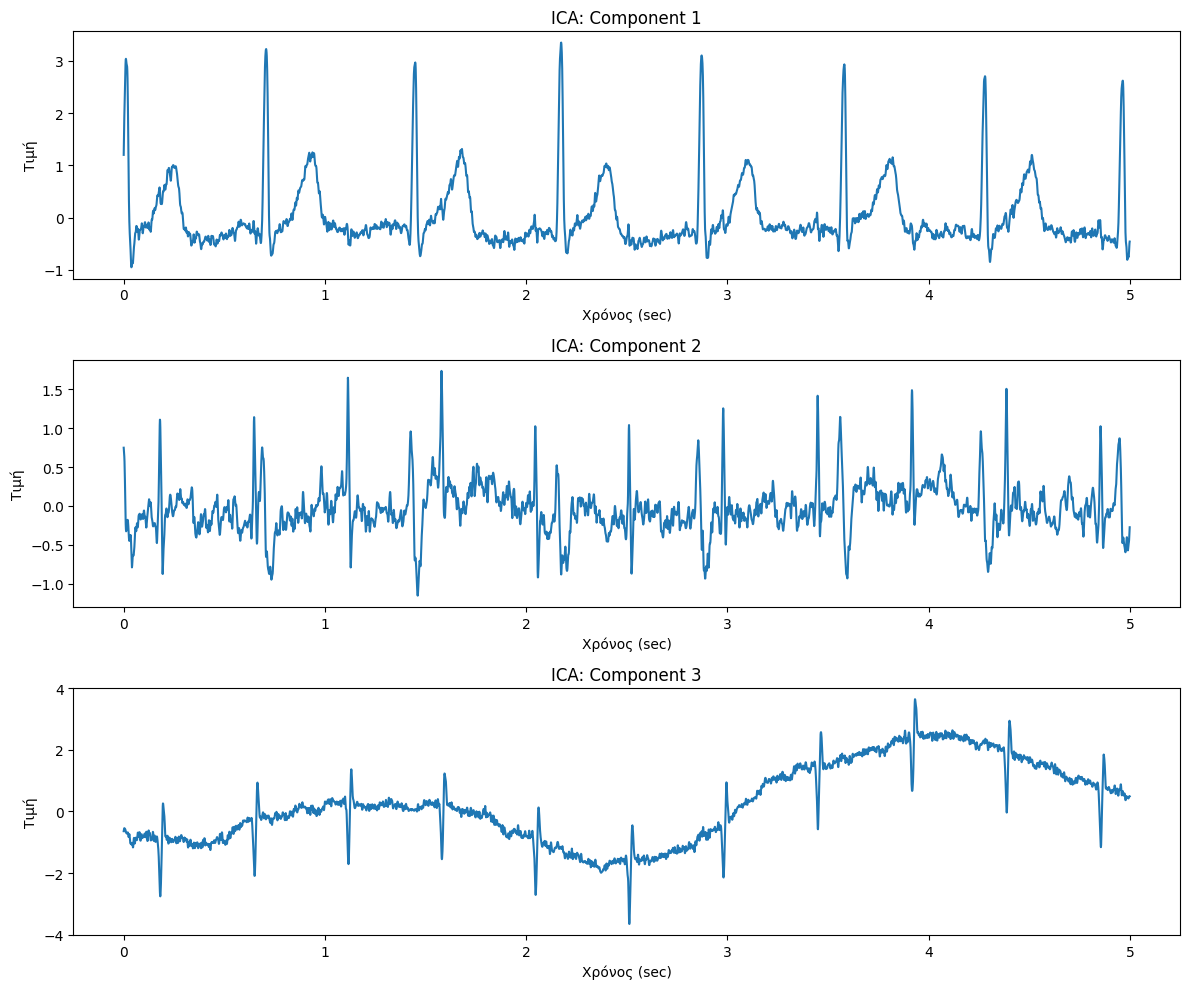

In [ ]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
ica = FastICA(n_components=3)
ica_components = ica.fit_transform(signals)  # ΟΧΙ filtered_signals !!!!!!!

# Οπτικοποίηση των αποτελεσμάτων (πρώτα 5 δευτερόλεπτα)
time = np.linspace(0, signals.shape[0]/fs, signals.shape[0])
first_n_sec_S = ica_components[:n_seconds * int(fs), :]

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(ica_components.shape[1], 1, i + 1)
    plt.plot(time[:n_seconds * int(fs)], first_n_sec_S[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

# FFT ✨

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Σχήμα signals: (300000, 5)


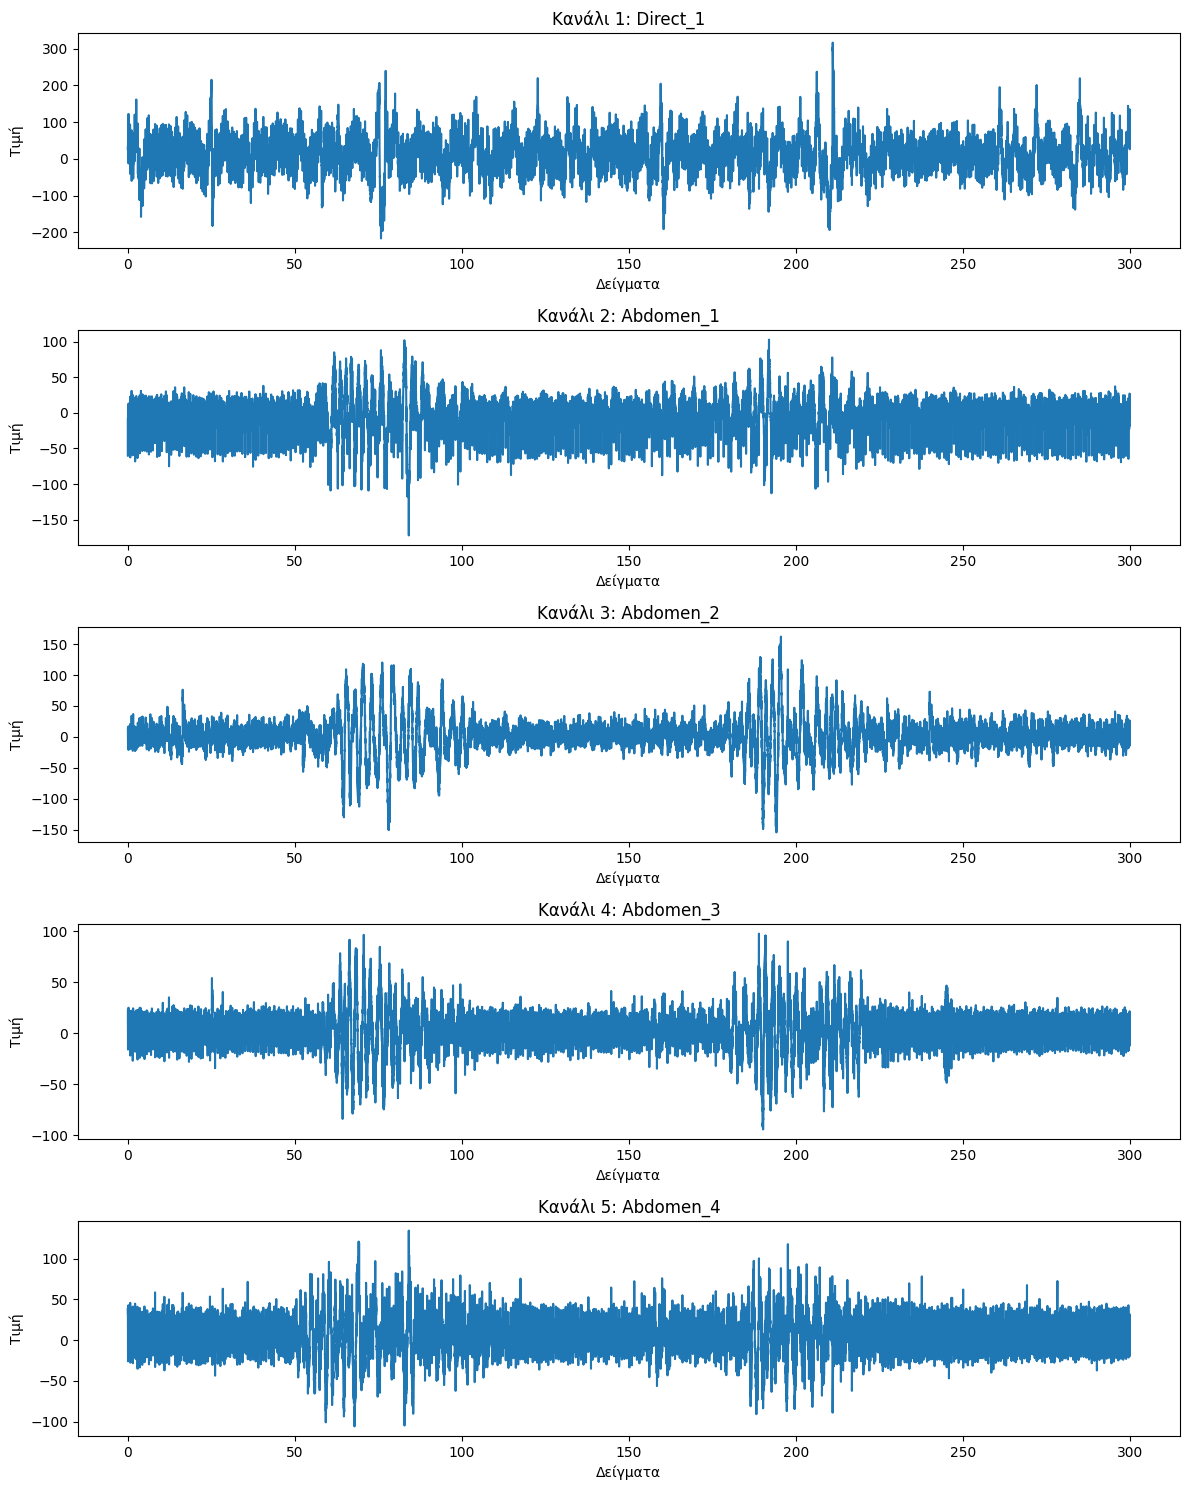

In [43]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
signals = np.array(signals_list).T
print("Σχήμα signals:", signals.shape)

n_samples = signals.shape[0]
time = np.arange(n_samples) / fs
n_channels = signals.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(time, signals[:, i])
    plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')

plt.tight_layout()
plt.show()


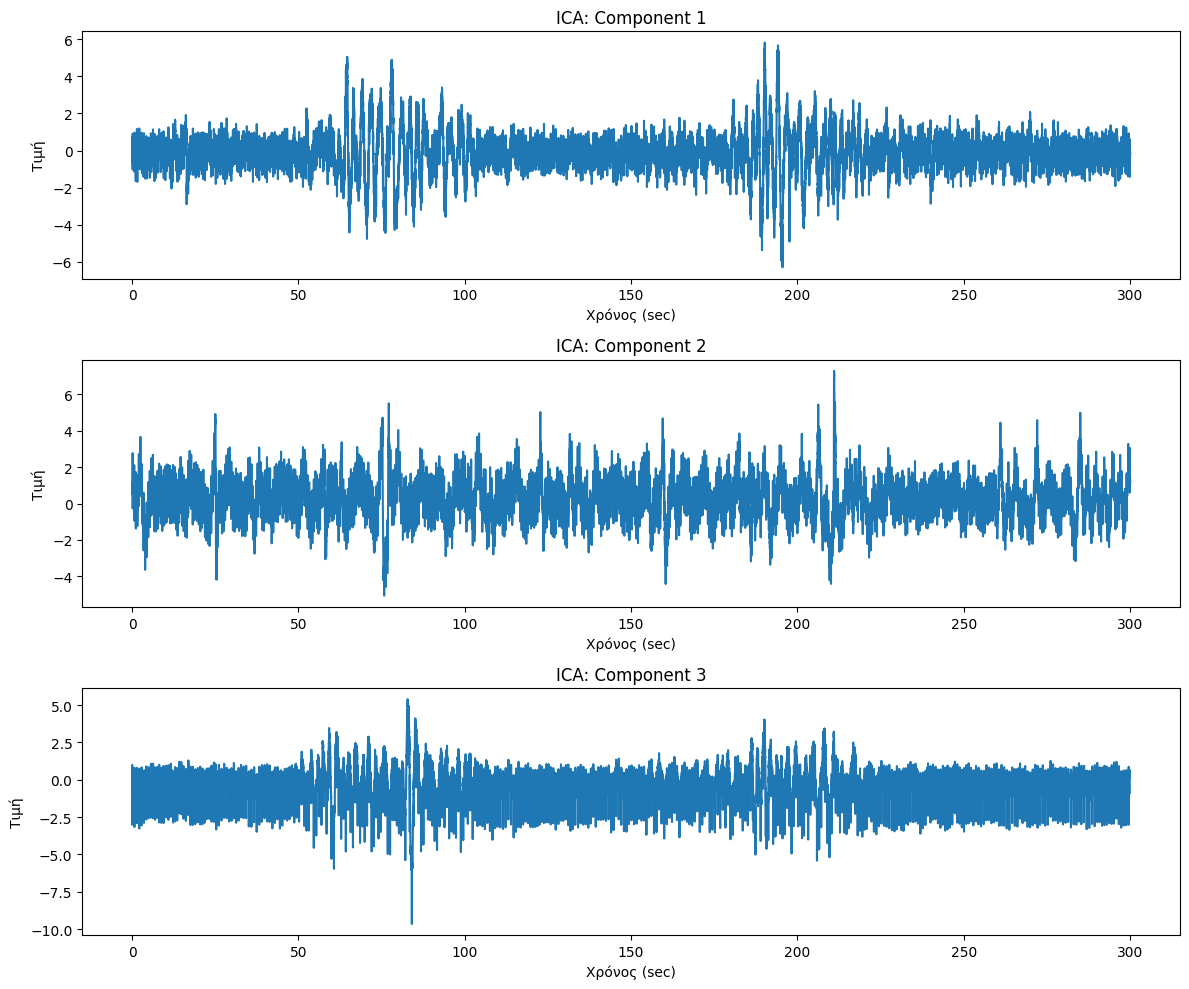

In [44]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
n_components = 3

ica = FastICA(n_components)
ica_components = ica.fit_transform(signals)  # ΟΧΙ filtered_signals !!!!!!!

time = np.arange(ica_components.shape[0]) / fs

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(ica_components.shape[1], 1, i + 1)
    plt.plot(time, ica_components[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# segment_duration = 10    # seconds
# samples_per_segment = fs * segment_duration

# # Determine number of complete segments available
# n_segments = ica_components.shape[0] // samples_per_segment

# # Loop over each ICA component
# for comp_idx in range(ica_components.shape[1]):
#     component = ica_components[:, comp_idx]

#     # Loop over each 10-second segment for the component
#     for seg_idx in range(n_segments):
#         start = seg_idx * samples_per_segment
#         end = start + samples_per_segment
#         segment = component[start:end]

#         # Compute FFT of the segment
#         fft_values = np.fft.fft(segment)
#         freqs = np.fft.fftfreq(len(segment), 1/fs)

#         # Consider only the positive frequencies
#         mask = freqs >= 0

#         # Plot the FFT magnitude
#         plt.figure(figsize=(8, 4))
#         plt.plot(freqs[mask], np.abs(fft_values)[mask])
#         plt.title(f'ICA Component {comp_idx+1} - Segment {seg_idx+1} (10 sec)')
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('Amplitude')
#         plt.grid(True)
#         plt.show()

In [54]:
import numpy as np

segment_duration = 10       # Duration of each segment in seconds
samples_per_segment = int(fs * segment_duration)
n_components = ica_components.shape[1]
n_segments = ica_components.shape[0] // samples_per_segment

maternal_band = (1.0, 1.7)  # Example band for maternal ECG
fetal_band = (2.0, 2.5)     # Example band for fetal ECG

# Initialize arrays to store power estimates
maternal_power = np.zeros(n_components)
fetal_power = np.zeros(n_components)

# Loop over each ICA component
for comp_idx in range(n_components):
    component = ica_components[:, comp_idx]

    # Arrays to store power in each segment for averaging later
    seg_maternal_power = []
    seg_fetal_power = []

    # Process each segment
    for seg_idx in range(n_segments):
        start = seg_idx * samples_per_segment
        end = start + samples_per_segment
        segment = component[start:end]

        # Compute FFT
        fft_values = np.fft.fft(segment)
        freqs = np.fft.fftfreq(len(segment), 1/fs)

        # Consider only positive frequencies
        mask = freqs >= 0
        fft_values = fft_values[mask]
        freqs = freqs[mask]

        # Compute power spectral density (or simply squared magnitude)
        psd = np.abs(fft_values)**2

        # Sum the power in the maternal band
        m_band_mask = (freqs >= maternal_band[0]) & (freqs <= maternal_band[1])
        seg_maternal_power.append(np.sum(psd[m_band_mask]))

        # Sum the power in the fetal band
        f_band_mask = (freqs >= fetal_band[0]) & (freqs <= fetal_band[1])
        seg_fetal_power.append(np.sum(psd[f_band_mask]))

    # Average power over segments
    maternal_power[comp_idx] = np.mean(seg_maternal_power)
    fetal_power[comp_idx] = np.mean(seg_fetal_power)


In [55]:

# Display the averaged band powers for each component
for comp_idx in range(n_components):
    print(f"Component {comp_idx+1}: Maternal band power = {maternal_power[comp_idx]:.2f}, " \
          f"Fetal band power = {fetal_power[comp_idx]:.2f}")

# Identify the likely fetal component:
# One approach: the component with the highest ratio of fetal to maternal power
ratios = fetal_power / (maternal_power + 1e-8)
print(f"The ratios are {ratios}")
fetal_component_idx = np.argmax(ratios)
print(f"Likely fetal ECG component is Component {fetal_component_idx+1}")


Component 1: Maternal band power = 1819513.14, Fetal band power = 445623.71
Component 2: Maternal band power = 2261110.86, Fetal band power = 409325.63
Component 3: Maternal band power = 3951391.82, Fetal band power = 263299.94
The ratios are [0.24491371 0.18102855 0.06663473]
Likely fetal ECG component is Component 1


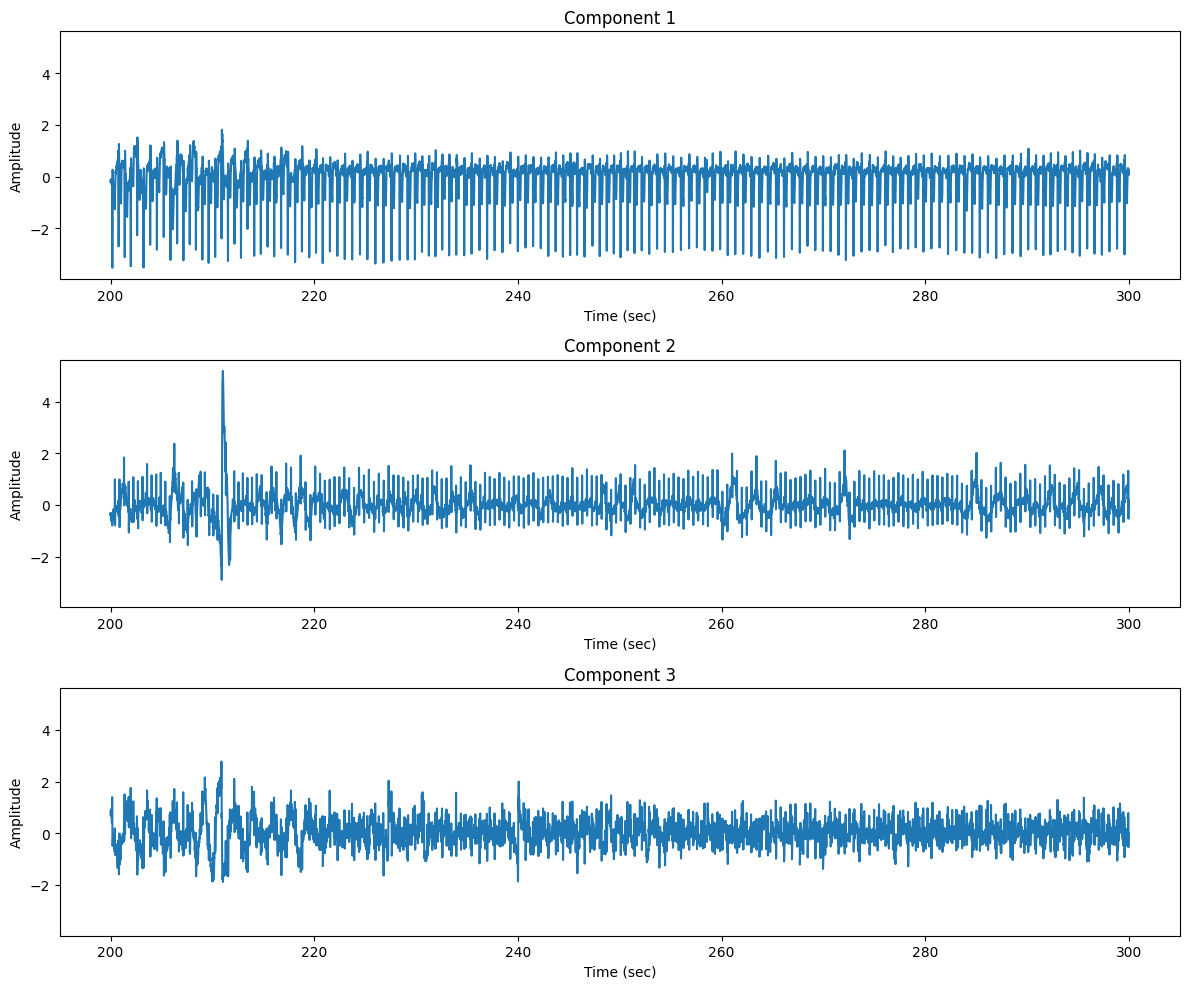

In [24]:
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[1]):
    filtered_signals[:, i] = bandpass_filter(
        data=ica_components[:, i],
        lowcut= 0.5,
        highcut=40,
        fs=fs,
    )

fig, axes = plt.subplots(3, 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[200000:], filtered_signals[200000:, i])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [46]:
print("ica_components.shape:", ica_components.shape)
print("ica_components[0].shape:", ica_components[0].shape)


ica_components.shape: (300000, 3)
ica_components[0].shape: (3,)


ica_components.shape: (300000, 3)
ica_components[0].shape (first row): (3,)


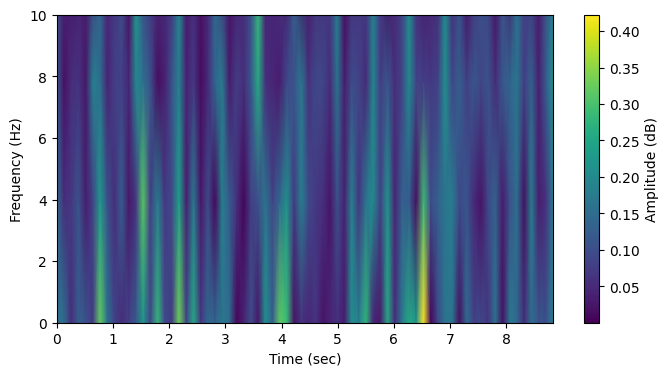

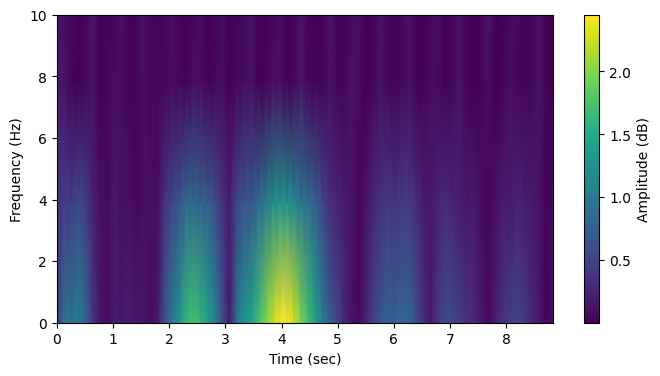

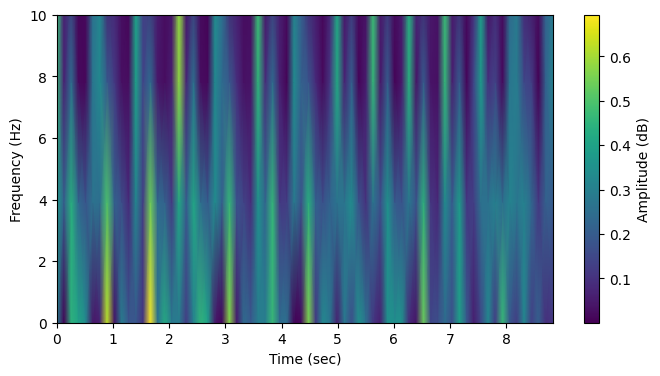

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

print("ica_components.shape:", ica_components.shape)
print("ica_components[0].shape (first row):", ica_components[0].shape)
time_limit = 70
for i in range(ica_components.shape[1]):
  # Compute the STFT on the selected component
  f, t, Zxx = stft(ica_components[:, i], fs=fs, nperseg=256)

  # print("Shape of f:", f.shape)
  # print("Shape of t:", t.shape)
  # print("Shape of Zxx:", Zxx.shape)

  # Plot the spectrogram
  plt.figure(figsize=(8, 4))
  plt.pcolormesh(t[:time_limit], f, np.abs(Zxx[:, :time_limit]), shading='gouraud')
  # plt.pcolormesh(t[:time_limit], f, 20*np.log10(np.abs(Zxx[:, :50]) + 1e-8), shading='gouraud')
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (sec)")
  plt.colorbar(label="Amplitude (dB)")
  plt.ylim([0, 10])
  plt.show()

<ipython-input-25-b9c2996cea15>:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)


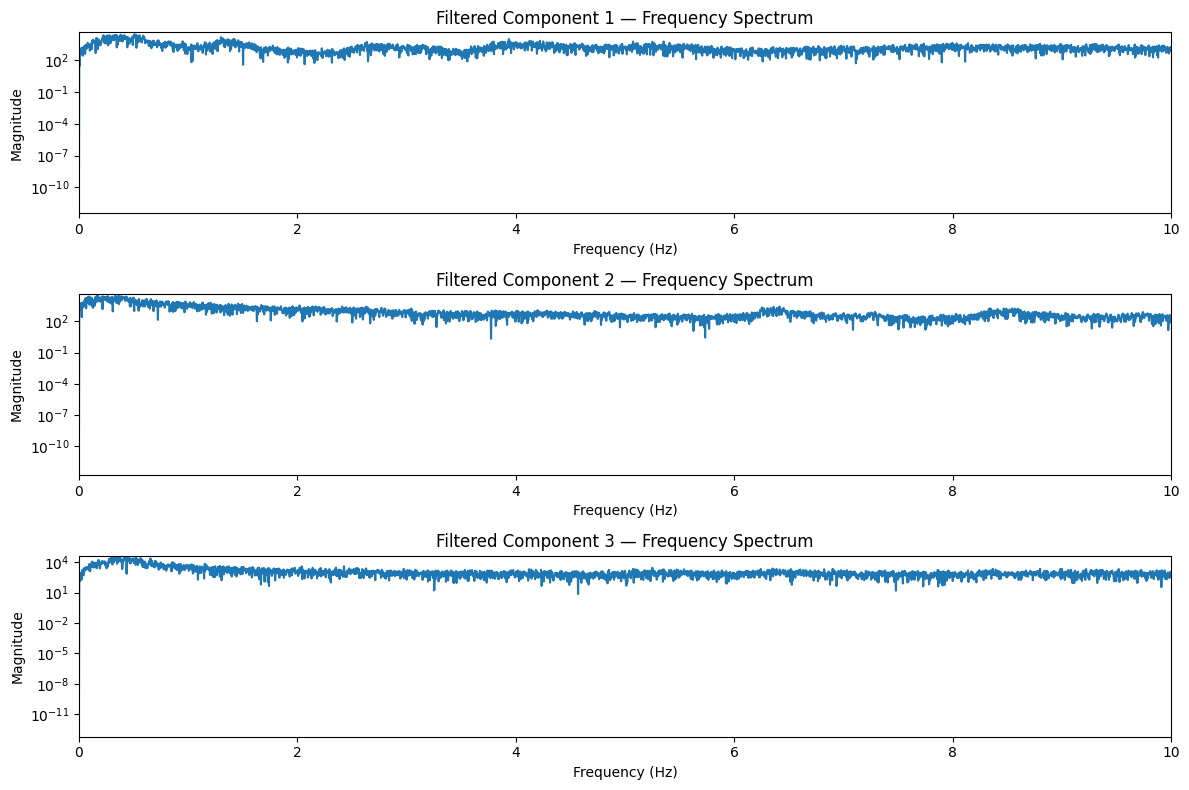

In [25]:
# Number of samples
n = ica_components.shape[0]

# Frequency axis
freqs = np.fft.rfftfreq(n, d=1/fs)

# Compute spectra
fft_vals_list = [
    np.abs(np.fft.rfft(ica_components[:, i]))
    for i in range(ica_components.shape[1])
]

# Replace any NaN or Inf with zero
fft_vals_list = [np.nan_to_num(vals, nan=0.0, posinf=0.0, neginf=0.0)
                 for vals in fft_vals_list]

# Global y‑limit
ymax = max(vals.max() for vals in fft_vals_list)

# Plot
plt.figure(figsize=(12, 8))
for i, fft_vals in enumerate(fft_vals_list):
    plt.subplot(ica_components.shape[1], 1, i+1)
    plt.plot(freqs, fft_vals)
    plt.title(f'Filtered Component {i+1} — Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.yscale('log')
    plt.ylabel('Magnitude')
    plt.xlim(0, 10)
    plt.ylim(0, ymax)
plt.tight_layout()
plt.show()



In [2]:
!pip install PyWavelets
import pywt


In [ ]:
# Parameters
time = np.arange(ica_components.shape[0]) / fs

# Choose wavelet + scales
wavelet = 'cmor1.5-1.0'        # complex Morlet
scales = np.arange(1, 128)    # adjust max scale for resolution

plt.figure(figsize=(12, 10))

for i in range(ica_components.shape[1]):
    signal = ica_components[:, i]

    # Compute CWT
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

    # Plot scalogram
    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)        # limit to fetal ECG band (~1–100 Hz)

plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.3 MB/s eta 0:00:00


KeyboardInterrupt: 

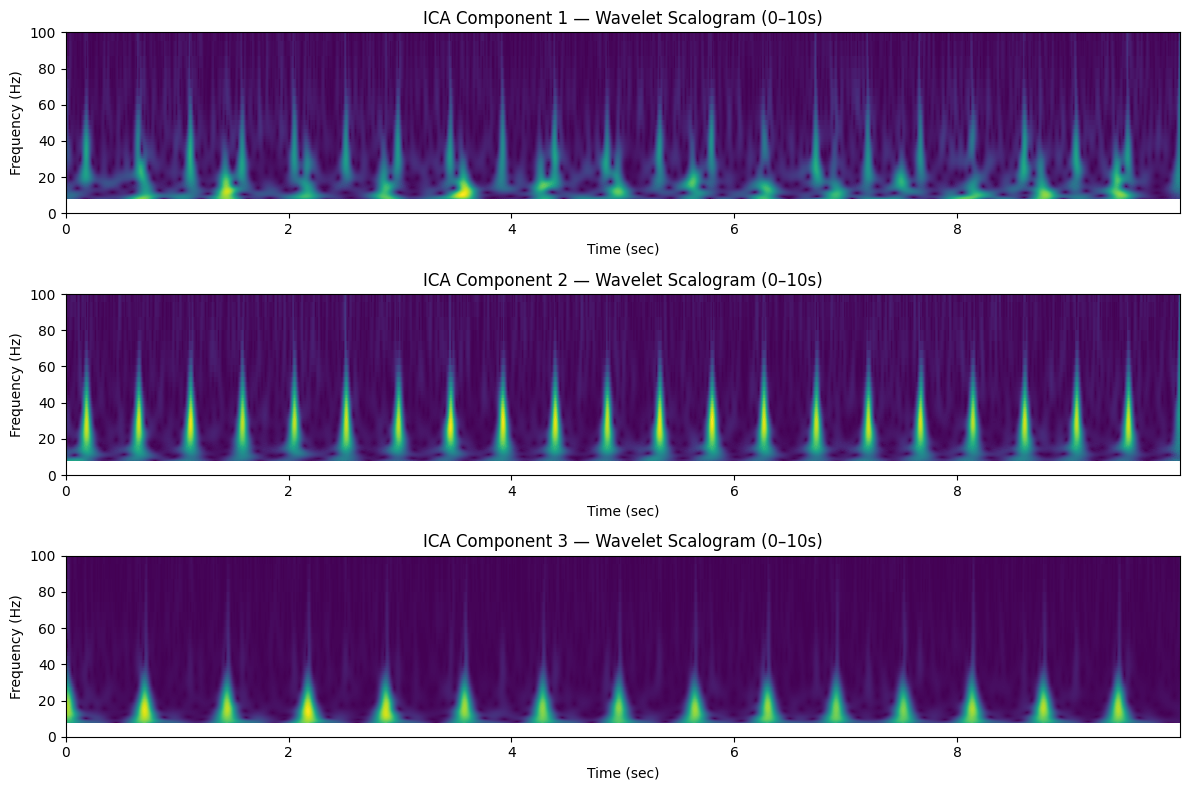

In [51]:
end_idx = int(10 * fs)
time_limit = time[:end_idx]
time = np.arange(ica_components.shape[0]) / fs

wavelet = 'cmor1.5-1.0'        # complex Morlet
scales = np.arange(1, 128)    # max scale for resolution

plt.figure(figsize=(12, 8))
for i in range(ica_components.shape[1]):
    sig10 = ica_components[:end_idx, i]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()